# TP Calibration

Read, understand, and complete and run the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). 

To execute a notebook, you will need to [install jupyter](http://jupyter.org/install.html). If you are using anaconda (strongly advised). If you cannot/don't want to use notebooks, you can return both your python code and a report in pdf. Note that the TPs was done using python2, if you are using python3, you might need to do a few changes to the provided code.


Imports:

In [1]:
import numpy as np 
# this is the key library for manipulating arrays. Use the online ressources! http://www.numpy.org/

import matplotlib.pyplot as plt 
# used to read images, display and plot http://matplotlib.org/api/pyplot_api.html . 
#You can also check this simple intro to using ipython notebook with images https://matplotlib.org/users/image_tutorial.html

%matplotlib inline 
# to display directly in the notebook

import scipy.ndimage as ndimage
# one of several python libraries for image procession

import scipy.io as sio
# usefull for loading mat files

import scipy.optimize as optimize
# usefull for optimization

import scipy.sparse

plt.rcParams['image.cmap'] = 'gray' 
# by default, the grayscale images are displayed with the jet colormap: use grayscale instead


from mpl_toolkits.mplot3d import Axes3D

Download the [data](http://imagine.enpc.fr/~aubrym/lectures/introvis17/clean_points.mat ). Load the data:

In [2]:
data=sio.loadmat('clean_points.mat')
pts2d=data['pts2d']
pts3d=data['pts3d']

pts3d_bis = np.hstack((pts3d, np.ones((len(pts2d), 1))))

n=len(pts2d)

pts2d and pts3d are two vector of corresponding points in the image and in 3D. We will use these correspondences to calibrate the camera.

1: Build the matrix A that defines the calibration equation (slide 72 in the lecture, the matrix A such that A.P=-1, P being the vector of the calibration matrix parameters and -1 being a vector)

In [3]:
def creer_A(pts2d, pts3d):
    A = np.zeros((2 * n, 3 * pts3d.shape[1]))
    N = np.zeros((2,3))
    N[0,1],N[1,0] =  1,1
    for i in range(n):
        N[0,2], N[1,2] = -pts2d[i, 1],-pts2d[i, 0]
        A[2*i:2*(i+1),:] = scipy.sparse.kron(N, pts3d[i]).toarray()
    return A

A = creer_A(pts2d,pts3d_bis)

2: Perform SVD (using np.linalg.svd) on A. Check that the SVD is coherent and that one of the singular value is close to 0. Use this SVD to compute the projection matrix.

In [4]:
x,y,z = np.linalg.svd(A)
print("La plus petite valeur singulière est",min(y))

La plus petite valeur singulière est 0.043161146146141936


3: Write a function that computes the error between the projected 3D points with a matrix P and the 2D points.

In [5]:
def creer_P(pts2d=pts2d, pts3d=pts3d_bis):
    A = creer_A(pts2d, pts3d)
    u, v, w = np.linalg.svd(A)
    return w[-1].reshape((3,4))

def projeter(P,pts3d=pts3d_bis):
    sp = pts3d @ (P.reshape(3,4).T)
    return (sp / sp[:,2,np.newaxis])[:,:2]
    
def error(P):
    proj = projeter(P)
    return np.linalg.norm(pts2d - proj)/len(pts2d)

P = creer_P()
print("L'erreur est de", error(P))

L'erreur est de 0.043204788560561466


4: Visualize the projected 3D points and the 2D points on the same figure (use plt.scatter with different 'marker' options)

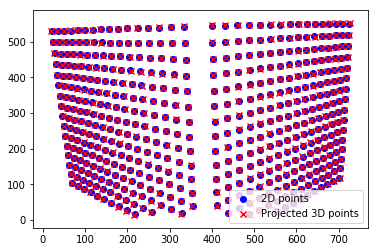

In [6]:
def afficher(P=P,pts2d=pts2d,pts3d=pts3d_bis):
    proj = projeter(P,pts3d)
    
    plt.scatter([i[0] for i in pts2d], [i[1] for i in pts2d], marker='o',c='b', label="2D points")
    plt.scatter([i[0] for i in proj], [i[1] for i in proj], marker='x',c='r', label="Projected 3D points")
    
    plt.legend()
    plt.show()
    
afficher()

5: Extract the intrinsic and extrinsic parameters of the camera from the matrix (slides 90-95, use np.linalg.norm, np.linalg.inv, np.dot, np.cross...)

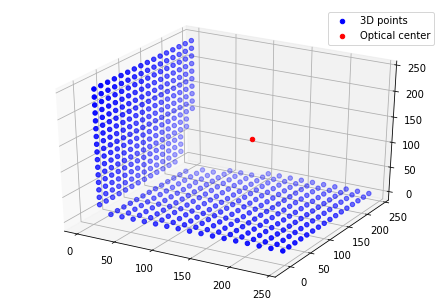

In [7]:
# i'm only using the formulas from the slides 90 to 95

a = np.array([[i[0],i[1],i[2]] for i in P])
b = np.array([i[3] for i in P])

# Let's suppose epsilon is equal to 1, check the result graphically and then conclude if it was the right choice
eps = 1


rho = eps / np.linalg.norm(a[2])
r = np.zeros_like(a)

r[2] = rho * a[2]

u0 = rho * np.dot(a[0], r[2])
v0 = rho * np.dot(a[1], r[2])

r[0] = np.cross(a[1], a[2]) / np.linalg.norm(np.cross(a[1], a[2]))
r[1] = np.cross(r[2], r[0])

cos_theta = - (np.dot(np.cross(a[0], a[2]), np.cross(a[1], a[2])))
cos_theta = cos_theta/ (np.linalg.norm(np.cross(a[0], a[2]))*np.linalg.norm(np.cross(a[1], a[2])))

sin_theta = np.sqrt(1 - cos_theta*cos_theta)

alpha = rho * rho * np.linalg.norm(np.cross(a[0], a[2])) * sin_theta
beta  = rho * rho * np.linalg.norm(np.cross(a[1], a[2])) * sin_theta

theta = np.arccos(cos_theta)

K = np.array([[alpha, -alpha * cos_theta/sin_theta, u0],
             [0, beta / sin_theta, v0],
             [0,0,1],])

t = rho * np.linalg.solve(K, b)

# Let's check if epsilon is indeed equal to 1 or not. With epsilon = 1, the optical center of the camera is there :
optical_center = np.linalg.solve(r, t)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter([i[0] for i in pts3d], [i[1] for i in pts3d], [i[2] for i in pts3d], c='b', label="3D points")
ax.scatter(optical_center[0], optical_center[1], optical_center[2],c='r', label="Optical center")
plt.legend()
plt.show()

In [8]:
# So the optical center of the camera wouldn't be OK if epsilon was equal to 1 (behind the object !)
# Thus, we have epsilon = -1

6: Improve the estimate of the camera matrix using non linear least square (use optimize.leastsq which implements a variant of Levenberg-Marquardt and the function of question 3) Compare the reprojection error before and after the optimization.

L'erreur avant optimisation est de 0.043204788560561466
L'erreur après optimisation est de 0.043151431698948264


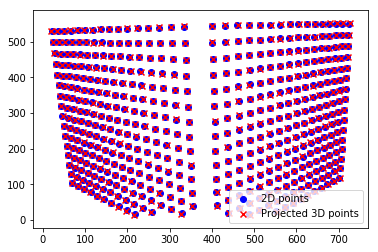

In [10]:
def error_bis(P):
    proj = projeter(P,pts3d_bis)
    return np.linalg.norm(pts2d - proj, axis=1)

P_bis,_ = optimize.leastsq( error_bis , P.reshape((12)))
print("L'erreur avant optimisation est de", error(P))
print("L'erreur après optimisation est de", error(P_bis))
afficher(P_bis)